In [2]:
import polars as pl
import numpy as np
import warnings
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import polars.selectors as cs

warnings.filterwarnings("ignore")

commission = 0.25 / 10000.0

In [3]:
result_hour = pl.read_parquet('./kline_1d_df.parquet')
result_hour = result_hour.sort('open_time','jj_code')
result_hour = result_hour.rename({"jj_code": "symbol"})

In [4]:
result_hour = result_hour.filter(
    (pl.col('open_time') >= pl.datetime(2024,1,1))
)
result_hour = result_hour.sort('close_time', 'symbol')

In [5]:
factors = result_hour.with_columns(
    ((pl.col('close') - pl.col('close').shift(1))/pl.col('close').shift(1)).over('symbol').alias('ret')
)
factors = factors.with_columns(
    (pl.col('ret').abs().rolling_sum(window_size=10)).over('symbol').alias('ret_sum')
)
factors = factors.with_columns(
    (pl.col('quote_volume').rolling_sum(window_size=10)).over('symbol').alias('volume_sum')
)
factors = factors.with_columns(
    (pl.col('ret_sum')/pl.col('volume_sum')).over('symbol').alias('amihud_ratio')
)
factors = factors.with_columns(
    (pl.col('amihud_ratio')+1).log().alias('amihud_ratio')
)

因子1：CLOSE
以收盘价作为因子数值，这个因子类似于市值因子

In [6]:
close = result_hour[["open_time", "symbol", "close"]].pivot(index="open_time", columns="symbol", values="close").sort("open_time")
volume = result_hour[["open_time", "symbol", "volume"]].pivot(index="open_time", columns="symbol", values="volume").sort("open_time")
columns = close.columns[1:]

# 因子写在这里：
factors = factors[["open_time", "symbol", 'amihud_ratio']].pivot(index="open_time", columns="symbol", values="amihud_ratio").sort("open_time")

# 因子未来收益率：
ret = close.clone()
ret[columns] = ret[columns].shift(-1) / ret[columns] - 1

# 对齐column
ret = ret[factors.columns] 
t = factors[["open_time"]] 

# 对齐open_time
ret = ret.join(t, how="inner", on=["open_time"]).sort(by=["open_time"]) 
factors = factors.sort(by=["open_time"])

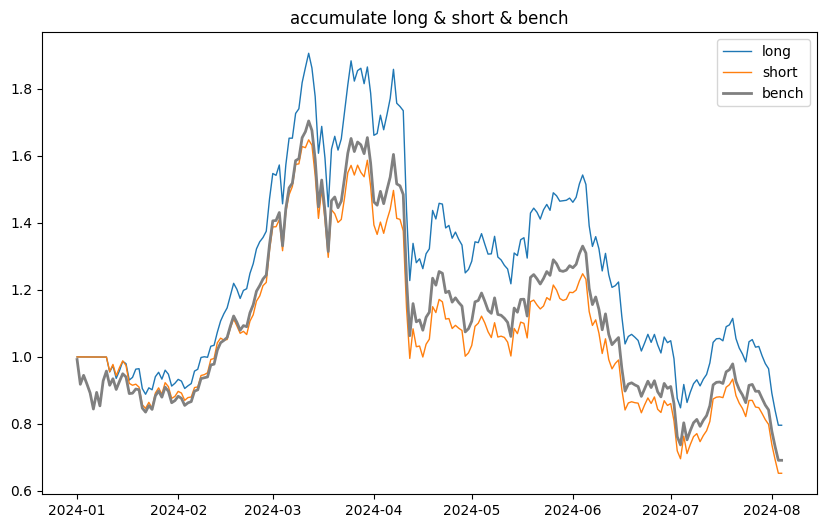

long: 
ann_return = -0.0946  sharpe = -0.1255  maxdd = 0.5824  calmar_ratio = -0.1625  

short: 
ann_return = -0.4302  sharpe = -0.5709  maxdd = 0.6039  calmar_ratio = -0.7124  

bench: 
ann_return = -0.3139  sharpe = -0.4033  maxdd = 0.5943  calmar_ratio = -0.5282  



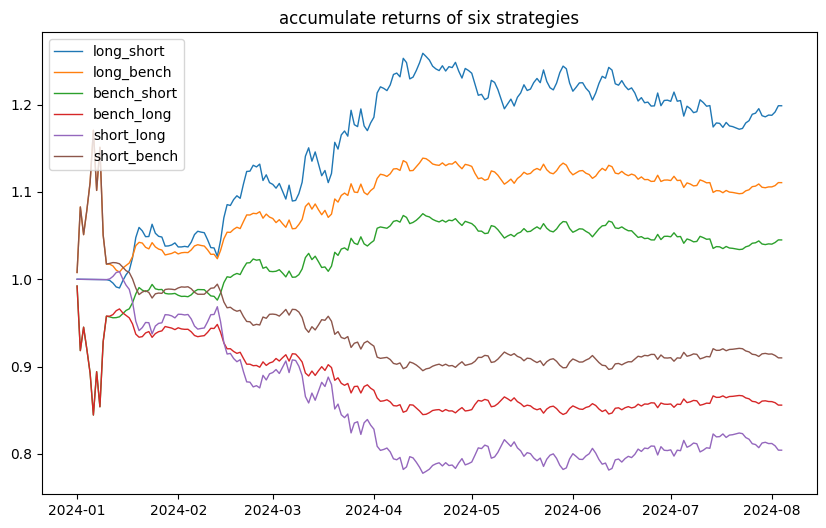

long_short: 
ann_return = 0.3173  sharpe = 2.0031  maxdd = 0.0691  calmar_ratio = 4.5913  

long_bench: 
ann_return = 0.201  sharpe = 0.9081  maxdd = 0.1388  calmar_ratio = 1.4488  

bench_short: 
ann_return = 0.098  sharpe = 0.4455  maxdd = 0.1489  calmar_ratio = 0.6584  

bench_long: 
ann_return = -0.2375  sharpe = -1.0729  maxdd = 0.1489  calmar_ratio = -1.5955  

short_long: 
ann_return = -0.3538  sharpe = -2.2335  maxdd = 0.229  calmar_ratio = -1.5452  

short_bench: 
ann_return = -0.1345  sharpe = -0.6114  maxdd = 0.2352  calmar_ratio = -0.5719  



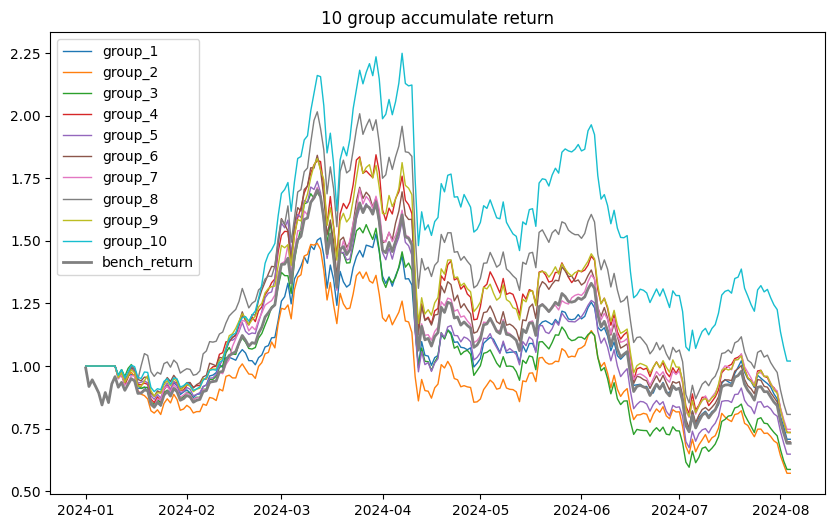

group_1: 
sharpe = -0.4535  ann_return = -0.3242  maxdd = 0.537  calmar_ratio = -0.6037  

group_2: 
sharpe = -0.8608  ann_return = -0.6516  maxdd = 0.6166  calmar_ratio = -1.0566  

group_3: 
sharpe = -0.7578  ann_return = -0.589  maxdd = 0.6532  calmar_ratio = -0.9017  

group_4: 
sharpe = -0.2614  ann_return = -0.205  maxdd = 0.6014  calmar_ratio = -0.3409  

group_5: 
sharpe = -0.4993  ann_return = -0.4001  maxdd = 0.6272  calmar_ratio = -0.6379  

group_6: 
sharpe = -0.3921  ann_return = -0.3031  maxdd = 0.6216  calmar_ratio = -0.4876  

group_7: 
sharpe = -0.2842  ann_return = -0.2105  maxdd = 0.5642  calmar_ratio = -0.3731  

group_8: 
sharpe = -0.0729  ann_return = -0.0565  maxdd = 0.5999  calmar_ratio = -0.0942  

group_9: 
sharpe = -0.3053  ann_return = -0.2301  maxdd = 0.5991  calmar_ratio = -0.3841  

group_10: 
sharpe = 0.4383  ann_return = 0.3395  maxdd = 0.5467  calmar_ratio = 0.6211  



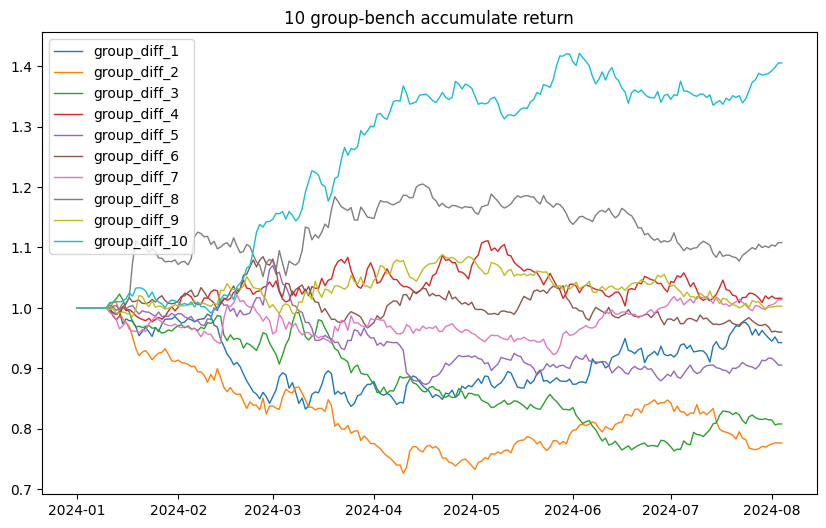

group_diff_1: 
sharpe = -0.3988  ann_return = -0.0795  maxdd = 0.1672  calmar_ratio = -0.4751  

group_diff_2: 
sharpe = -2.1409  ann_return = -0.4068  maxdd = 0.2806  calmar_ratio = -1.4496  

group_diff_3: 
sharpe = -2.0764  ann_return = -0.3442  maxdd = 0.2536  calmar_ratio = -1.3575  

group_diff_4: 
sharpe = 0.2449  ann_return = 0.0397  maxdd = 0.097  calmar_ratio = 0.4094  

group_diff_5: 
sharpe = -1.0157  ann_return = -0.1554  maxdd = 0.1838  calmar_ratio = -0.8453  

group_diff_6: 
sharpe = -0.4109  ann_return = -0.0583  maxdd = 0.1149  calmar_ratio = -0.5078  

group_diff_7: 
sharpe = 0.2271  ann_return = 0.0343  maxdd = 0.0965  calmar_ratio = 0.3549  

group_diff_8: 
sharpe = 1.0567  ann_return = 0.1883  maxdd = 0.1056  calmar_ratio = 1.7828  

group_diff_9: 
sharpe = 0.1049  ann_return = 0.0146  maxdd = 0.0826  calmar_ratio = 0.1773  

group_diff_10: 
sharpe = 3.7965  ann_return = 0.5843  maxdd = 0.0605  calmar_ratio = 9.6584  



In [7]:
factors_np = factors[columns].to_numpy()
ret_np = ret[columns].to_numpy()

def factor_stats(n, pnl):
    net_value = (1 + pnl).cum_prod()
    sharpe = n ** 0.5 * pnl.mean() / pnl.std()
    ann_return = n * pnl.mean()
    maxdd = (-(net_value / net_value.cum_max() - 1)).max()
    calmar_ratio = ann_return / maxdd

    print("ann_return =", round(ann_return, 4), end='  ')
    print("sharpe =", round(sharpe, 4), end='  ')
    print("maxdd =", round(maxdd, 4), end='  ')
    print("calmar_ratio =", round(calmar_ratio, 4), end='  ')


percentage = 0.5
quantiles = np.nanquantile(factors_np, [1 - percentage, percentage], axis=1)

f = lambda x: quantiles[x][:, None].repeat(factors_np.shape[1], axis=-1)
long_quantile, short_quantile = f(0), f(1)

# return before fee
long = np.nan_to_num(np.nan_to_num(ret_np * (factors_np > long_quantile), 0.0).sum(axis=1) / (factors_np > long_quantile).sum(axis=1) , 0.0)
short = np.nan_to_num(np.nan_to_num(ret_np * (factors_np < long_quantile), 0.0).sum(axis=1) / (factors_np < long_quantile).sum(axis=1) , 0.0)
bench = np.nan_to_num(np.nanmean(ret_np, axis=1), 0.0)

# return after fee
long_fee = pl.Series(long - 2 * commission)
short_fee = pl.Series(short - 2 * commission)
bench_fee = pl.Series(bench - 2 * commission)

long_short = pl.Series(long - short - 2 * commission)
long_bench = pl.Series(long - bench - 2 * commission)
bench_short = pl.Series(bench - short - 2 * commission)
bench_long = pl.Series(bench - long - 2 * commission)
short_long = pl.Series(short - long - 2 * commission)
short_bench = pl.Series(short - bench - 2 * commission)


long_cum = (1 + long_fee).cum_prod()
short_cum = (1 + short_fee).cum_prod()
bench_cum = (1 + bench_fee).cum_prod()

long_short_cum = (1 + long_short).cum_prod()
long_bench_cum = (1 + long_bench).cum_prod()
bench_short_cum = (1 + bench_short).cum_prod()
bench_long_cum = (1 + bench_long).cum_prod()
short_long_cum = (1 + short_long).cum_prod()
short_bench_cum = (1 + short_bench).cum_prod()


plt.figure(figsize=(10, 6))
plt.plot(factors["open_time"].to_pandas(), long_cum.to_pandas(), label='long', linewidth=1)
plt.plot(factors["open_time"].to_pandas(), short_cum.to_pandas(), label='short', linewidth=1)
plt.plot(factors["open_time"].to_pandas(), bench_cum.to_pandas(), label='bench', linewidth=2, color="gray")
plt.title("accumulate long & short & bench")
plt.legend()
plt.show()

# 因子评价指标
# n = 365 * 24 #小时
n = 365 #天
# n = 52 #周
print("long: ")
factor_stats(n, long_fee)
print("\n")
print("short: ")
factor_stats(n, short_fee)
print("\n")
print("bench: ")
factor_stats(n, bench_fee)
print("\n")


plt.figure(figsize=(10, 6))
plt.plot(factors["open_time"].to_pandas(), long_short_cum.to_pandas(), label='long_short', linewidth=1)
plt.plot(factors["open_time"].to_pandas(), long_bench_cum.to_pandas(), label='long_bench', linewidth=1)
plt.plot(factors["open_time"].to_pandas(), bench_short_cum.to_pandas(), label='bench_short', linewidth=1)
plt.plot(factors["open_time"].to_pandas(), bench_long_cum.to_pandas(), label='bench_long', linewidth=1)
plt.plot(factors["open_time"].to_pandas(), short_long_cum.to_pandas(), label='short_long', linewidth=1)
plt.plot(factors["open_time"].to_pandas(),short_bench_cum.to_pandas(), label='short_bench', linewidth=1)
plt.title("accumulate returns of six strategies")
plt.legend()
plt.show()


# 因子评价指标
print("long_short: ")
factor_stats(n, long_short)
print("\n")

print("long_bench: ")
factor_stats(n, long_bench)
print("\n")

print("bench_short: ")
factor_stats(n, bench_short)
print("\n")

print("bench_long: ")
factor_stats(n, bench_long)
print("\n")

print("short_long: ")
factor_stats(n, short_long)
print("\n")

print("short_bench: ")
factor_stats(n, short_bench)
print("\n")

###################################################################################################################

quantiles = np.nanquantile(factors_np, np.linspace(0, 1, 11), axis=1)
total_count = np.count_nonzero(~np.isnan(factors_np), axis=1)
f = lambda x: quantiles[x][:, None].repeat(factors_np.shape[1], axis=-1)

#bench_return = np.nan_to_num(ret_np, 0.0).mean(axis=1)
bench_return = np.nan_to_num(np.nanmean(ret_np, axis=1), 0.0)
bench_return_fee = np.nan_to_num(np.nanmean(ret_np, axis=1), 0.0) - 2 * commission
group_return = np.zeros((factors_np.shape[0], 10))
group_diff_return = np.zeros((factors_np.shape[0], 10))

for i in range(1, 11):
    # 计算在当前分位数范围内的总收益。如果因子值位于该分位数的范围内，则相应的收益被计入总和。
    ret_sum = np.nan_to_num(ret_np * (f(i-1) <= factors_np) * (factors_np <= f(i)), 0.0).sum(axis=1)
    # 计算当前分位数范围内的有效数据点数
    ret_count = np.nan_to_num((f(i-1) <= factors_np) * (factors_np <= f(i)), 0.0).sum(axis=1)
    group_return[:, i-1] = ret_sum / ret_count - 2 * commission 
    group_diff_return[:, i-1] = ret_sum / ret_count - bench_return - 2 * commission


group_return = np.nan_to_num(group_return)
group_diff_return = np.nan_to_num(group_diff_return)


plt.figure(figsize=(10, 6))
plt.title("10 group accumulate return")
for i in range(10):
    plt.plot(factors["open_time"].to_pandas(), np.cumprod(1 + group_return[:, i]), label=f"group_{i+1}", linewidth=1)
plt.plot(factors["open_time"].to_pandas(), np.cumprod(1 + bench_return_fee), label=f"bench_return", linewidth=2, color="gray")
plt.legend()
plt.show()

for i in range(10):
    print(f"group_{i+1}: ")
    net_value = np.cumprod(1 + group_return[:, i])
    sharpe = n ** 0.5 * group_return[:, i].mean() / group_return[:, i].std()
    ann_return = n * group_return[:, i].mean()
    maxdd = (-(net_value / np.maximum.accumulate(net_value) - 1)).max()
    calmar_ratio = ann_return / maxdd
    print("sharpe =", round(sharpe, 4), end='  ')
    print("ann_return =", round(ann_return, 4), end='  ')
    print("maxdd =", round(maxdd, 4), end='  ')
    print("calmar_ratio =", round(calmar_ratio, 4), end='  ')
    print("\n")


plt.figure(figsize=(10, 6))
plt.title("10 group-bench accumulate return")
for i in range(10):
    plt.plot(factors["open_time"].to_pandas(), np.cumprod(1 + group_diff_return[:, i]), label=f"group_diff_{i+1}", linewidth=1)
plt.legend()
plt.show()

for i in range(10):
    print(f"group_diff_{i+1}: ")
    net_value = np.cumprod(1 + group_diff_return[:, i])
    sharpe = n ** 0.5 * group_diff_return[:, i].mean() / group_diff_return[:, i].std()
    ann_return = n * group_diff_return[:, i].mean()
    maxdd = (-(net_value / np.maximum.accumulate(net_value) - 1)).max()
    calmar_ratio = ann_return / maxdd
    print("sharpe =", round(sharpe, 4), end='  ')
    print("ann_return =", round(ann_return, 4), end='  ')
    print("maxdd =", round(maxdd, 4), end='  ')
    print("calmar_ratio =", round(calmar_ratio, 4), end='  ')
    print("\n")